# Tutorial Wk8 Solutions: Text Processing as Unstructured Data

## EXERCISE: SMS spam filtering with naive Bayes

[Adapted from http://radimrehurek.com/data_science_python/.]

Other references:
* http://sebastianraschka.com/Articles/2014_naive_bayes_1.html
* http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
* https://gist.github.com/zacstewart/5978000

Other options:
* http://scikit-learn.org/stable/datasets/#the-20-newsgroups-text-dataset
* http://scikit-learn.org/stable/datasets/#rcv1-dataset

### Download data from UCI ML data repo

In [1]:
import os
import urllib
import zipfile

DATA_URI = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
DATA_DIR = 'data'
ARCHIVE_NAME = 'smsspamcollection.zip'
FILE_NAME = 'SMSSpamCollection'

# set up paths (in portable, OS-agnostic way)
local_archive_path = os.path.join(DATA_DIR, ARCHIVE_NAME)
local_file_path = os.path.join(DATA_DIR, FILE_NAME)

# set up local data directory
os.makedirs(DATA_DIR, exist_ok=True)

# save file from DATA_URI to local_path
urllib.request.urlretrieve(DATA_URI, local_archive_path)

# extract content from archive
z = zipfile.ZipFile(local_archive_path, 'r')
z.extractall(DATA_DIR)
z.close()

### Read and profile data using Pandas

Pandas provides tools that streamline some of the data analysis and visualisation work we've done in previous exercises. 

[DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) is the most commonly used data structure in Pandas. It is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table.

Let's use it now to read and profile our spam data.

In [2]:
import csv
import pandas

messages = pandas.read_csv(local_file_path, sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print(messages)

# view aggregate statistics
messages.groupby('label').describe()

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5569  spam  This is the 2nd time we have tried 2 contact u...
5570   ham               Will ü b going to esplanade fr home?
5571   ham  Pity, * was in mood for that. So...any other s...
5572   ham  The guy did some bitching but I acted like i'd...
5573   ham                         Rofl. Its true to its name

[5574 rows x 2 columns]


message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

### Text feature extraction

- It's easy for humans to see the patterns that distinguish ham and spam messages. What kind of features could we feed to a machine learning algorithm?

Feeding raw text data (e.g., "Sorry, I'll call later") to a machine learning algorithm would not be very useful. As a first step let's assume that there is a systematic difference between the words used for spam and ham.

`scikit-learn` includes [several functions for creating feature vectors from text](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction). These first tokenise -- split strings into words (e.g., "Sorry", "I'll", "call", "later").

Then then create feature vectors where indices correspond to a specific word and values correspond to the frequency of the corresponding word. 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# First split in to train and test sets
X_train, X_test, y_train, y_test = train_test_split(messages.message, messages.label, test_size=0.30,
                                                    random_state=5) # so we get the same results

# Fit and transform training to feature vectors of words
v = CountVectorizer(binary=True, lowercase=False)
X_train_bin = v.fit_transform(X_train)
print(X_train_bin.shape)

# scikit-learn vectorisers produce sparse array representations.
# These store only observed features for each instance instead of a complete vector.
# They're great for working with text data, but require a bit of work to inspect.

# View feature names
print('Feature names:\n', v.get_feature_names()[:10])

# View complete feature vector for row 0 as a list of words
def iter_features(X, row, names):
    for i in X[row].indices:
        yield names[i]
print('\nFeature words for row 0:\n', list(iter_features(X_train_bin, 0, v.get_feature_names())))

# Compare to original data
print('\nOriginal string for row0:\n', X_train.iloc[0])

(3901, 8928)
Feature names:
 ['00', '000', '000pes', '008704050406', '0089', '0121', '01223585236', '01223585334', '0125698789', '02']

Feature words for row 0:
 ['Ofcourse', 'also', 'upload', 'some', 'songs']

Original string for row0:
 Ofcourse I also upload some songs


### Build pipelines and choose parameters

`scikit-learn` includes pipeline functionality that makes it possible to specify and optimise a sequence of actions.

Let's see whether the results in [Wang and Manning (2012)](http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) hold for the SMS spam data we're using here.

Specifically we will compare multinomial naive Bayes to support vector machine with a degree-2 polynomial kernel. We will choose the best feature representation for both:
* binary vs term frequency vs tfidf
* unigrams vs bigrams

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Pipeline for multinomial naive Bayes
mnb = Pipeline([('vect', CountVectorizer(lowercase=False)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())
               ])

# Pipeline for polynomial support vector machine
svm = Pipeline([('vect', CountVectorizer(lowercase=False)),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(C=0.1, penalty='l2'))
               ])

# Grid search parameters
param_grid = [{'vect__binary': [True],
               'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': [True, False]
              },
              {'vect__binary': [False],
               'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': [True, False]
              }
             ]

# Find best parameters for MNB and SVM
gs_mnb = GridSearchCV(mnb, param_grid)
gs_mnb.fit(X_train, y_train)
print('\nMNB best params:\n', gs_mnb.best_params_)

gs_svm = GridSearchCV(svm, param_grid)
gs_svm.fit(X_train, y_train)
print('\nSVM best params:\n', gs_svm.best_params_)

# Print accuracy
print('\nMNB test result:\n', classification_report(y_test, gs_mnb.predict(X_test)))
print('\nSVM test result:\n', classification_report(y_test, gs_svm.predict(X_test)))


MNB best params:
 {'tfidf__use_idf': True, 'vect__binary': True, 'vect__ngram_range': (1, 1)}

SVM best params:
 {'tfidf__use_idf': False, 'vect__binary': True, 'vect__ngram_range': (1, 1)}

MNB test result:
               precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1436
        spam       1.00      0.69      0.82       237

    accuracy                           0.96      1673
   macro avg       0.98      0.85      0.90      1673
weighted avg       0.96      0.96      0.95      1673


SVM test result:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1436
        spam       0.99      0.78      0.87       237

    accuracy                           0.97      1673
   macro avg       0.98      0.89      0.93      1673
weighted avg       0.97      0.97      0.97      1673



### EXAMPLE SOLUTION: Handling class imbalance with SVM

- Which is better? Do we care about overall performance or just one of our classes? How does this compare to Wang and Manning's result?
- The `fit()` method for `LinearSVC` includes the `class_weight` parameter with can help deal with imbalanced data. The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`. Train a new SVM model with the best grid search parameters and `class_weight='balanced'`. Is this result better?
- Is there a more appropriate scoring function we could pass to `GridSearchCV` (using `sklearn.metrics.make_scorer`)? Does this give different MNB or SVM results for the parameter grid above?

In [9]:
# 1 - SVM gives a better result for spam, which is the category of interest.
#     Since it's the minority category in a binary problem,
#     we should be looking at precision and recall for spam only.

# 2 - Spam recall and f-score are better while precision is worse.
#     Which to deploy depends on the appropriate precision/recall tradeoff for users.
svm2 = Pipeline([('vect', CountVectorizer(lowercase=False, binary=True, ngram_range=(1,1))),
                 ('tfidf', TfidfTransformer(use_idf=False)),
                 ('clf', LinearSVC(C=0.1, penalty='l2', class_weight='balanced'))
                ])
svm2.fit(X_train, y_train)
print('\nSVM2 test result:\n', classification_report(y_test, svm2.predict(X_test)))

# 3 - We can use `f1_score` with `pos_label='spam'` and `average='binary'`.
#     This gives the same results for this parameter grid, but could be used to choose the best `class_weight`.
#     Note with fbeta_score, we could also specify whether we prefer precision or recall.
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, pos_label='spam', average='binary')
gs_mnb2 = GridSearchCV(mnb, param_grid, scoring=f1_scorer)
gs_mnb2.fit(X_train, y_train)
print('\nMNB GS2 best params:\n', gs_mnb2.best_params_)

gs_svm2 = GridSearchCV(svm, param_grid, scoring=f1_scorer)
gs_svm2.fit(X_train, y_train)
print('\nSVM GS2 best params:\n', gs_svm2.best_params_)

print('\nMNB GS2 test result:\n', classification_report(y_test, gs_mnb2.predict(X_test)))
print('\nSVM GS2 test result:\n', classification_report(y_test, gs_svm2.predict(X_test)))


SVM2 test result:
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1436
        spam       0.92      0.93      0.92       237

    accuracy                           0.98      1673
   macro avg       0.95      0.96      0.95      1673
weighted avg       0.98      0.98      0.98      1673


MNB GS2 best params:
 {'tfidf__use_idf': True, 'vect__binary': True, 'vect__ngram_range': (1, 1)}

SVM GS2 best params:
 {'tfidf__use_idf': False, 'vect__binary': True, 'vect__ngram_range': (1, 1)}

MNB GS2 test result:
               precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1436
        spam       1.00      0.69      0.82       237

    accuracy                           0.96      1673
   macro avg       0.98      0.85      0.90      1673
weighted avg       0.96      0.96      0.95      1673


SVM GS2 test result:
               precision    recall  f1-score   support

         ham       0.97   

## EXERCISE: Natural language parsing with SpaCy

[Adapted from https://nicschrading.com/project/Intro-to-NLP-with-spaCy/.]

### Load English parser

`parser = English()` will initialise the models for core English language processing.

We'll use some text from the first chapter of Alice in Wonderland, which is available from Project Gutenberg.

Perhaps enjoy reading while waiting for the models to load (may take a minute or two). ;)

In [11]:
# Set up spaCy
from spacy.lang.en import English
parser = English()

# Our text data from Ch1 of Alice in Wonderland
alice = """
Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do. Once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, "and what is the use of a book," thought Alice, "without pictures or
conversations?"

So she was considering in her own mind (as well as she could, for the
day made her feel very sleepy and stupid), whether the pleasure of
making a daisy-chain would be worth the trouble of getting up and
picking the daisies, when suddenly a White Rabbit with pink eyes ran
close by her.

There was nothing so very remarkable in that, nor did Alice think it so
very much out of the way to hear the Rabbit say to itself, "Oh dear! Oh
dear! I shall be too late!" But when the Rabbit actually took a watch
out of its waistcoat-pocket and looked at it and then hurried on, Alice
started to her feet, for it flashed across her mind that she had never
before seen a rabbit with either a waistcoat-pocket, or a watch to take
out of it, and, burning with curiosity, she ran across the field after
it and was just in time to see it pop down a large rabbit-hole, under
the hedge. In another moment, down went Alice after it!
"""

# Run the parser
parser.add_pipe('sentencizer')     # for latest spacy 2.0.x, sentencizer needs to be added.
parsedData = parser(alice)

### Print sentences and tokens

The result splits out sentences and tokens within sentences. Let's have a look.

In [12]:
sentences = list(parsedData.sents)
for i, s in enumerate(sentences):
    tokens = [t.text for t in s if t.text.strip()]
    print(i, ' '.join(tokens))

0 Alice was beginning to get very tired of sitting by her sister on the bank , and of having nothing to do .
1 Once or twice she had peeped into the book her sister was reading , but it had no pictures or conversations in it , " and what is the use of a book , " thought Alice , " without pictures or conversations ? "
2 So she was considering in her own mind ( as well as she could , for the day made her feel very sleepy and stupid ) , whether the pleasure of making a daisy - chain would be worth the trouble of getting up and picking the daisies , when suddenly a White Rabbit with pink eyes ran close by her .
3 There was nothing so very remarkable in that , nor did Alice think it so very much out of the way to hear the Rabbit say to itself , " Oh dear !
4 Oh dear !
5 I shall be too late ! "
6 But when the Rabbit actually took a watch out of its waistcoat - pocket and looked at it and then hurried on , Alice started to her feet , for it flashed across her mind that she had never before se

### Print linguistic analysis

The result also includes lemmas, part-of-speech (POS) tags, entity tags and grammatical dependencies.

In [13]:
print('-'*79)
print('{:<15} {:<15} {:<15} {:<15} {:<15}'.format('TOKEN', 'LEMMA', 'POS', 'ENTITY', 'DEPENDENCY'))
print('-'*79)
for token in sentences[0]:
    if token.text.strip():
        ent_tag = token.ent_iob_
        if token.ent_type_:
            ent_tag = '{}-{}'.format(token.ent_iob_, token.ent_type_)
        dep_rel = token.dep_
        if token.dep_ != 'ROOT':
            dep_rel = '{}::{}'.format(token.dep_, token.head.text)
        print('{:<15} {:<15} {:<15} {:<15} {:<15}'.format(token.text, token.lemma_, token.pos_, ent_tag, dep_rel))
print('-'*79)

-------------------------------------------------------------------------------
TOKEN           LEMMA           POS             ENTITY          DEPENDENCY     
-------------------------------------------------------------------------------
Alice                                                           ::Alice        
was                                                             ::was          
beginning                                                       ::beginning    
to                                                              ::to           
get                                                             ::get          
very                                                            ::very         
tired                                                           ::tired        
of                                                              ::of           
sitting                                                         ::sitting      
by                                      

### TODO Using parse data

- Copy and paste the raw text for the first sentence into SpaCy's online demonstrator at https://spacy.io/demos/displacy. This gives a visual representation of the dependency graph.
- Parse some news text (e.g., http://www.bbc.com/news/world-asia-china-36309063). Alternatively, view a parse using the demonstrator (e.g., https://spacy.io/demos/displacy?share=5036304037475277146). How could we use dependency relations to extract relationships from this data (e.g., `chairman-of<"Mr Zhang", "National People's Congress Standing Committee">`)?
- How could we use SpaCY to include more linguistic analysis in our text classification and forecasting systems? If you have time, try some of these ideas (e.g., https://www.site.uottawa.ca/eng/school/publications/techrep/2007/TR-2007-12.pdf).

## DATA2901 EXERCISE: Forecasting movie gross with support vector regression

Imagine you have an opportunity to invest in films after seeing descriptions. Perhaps you run a cinema and need to decide which films to show. If we could predict box office gross based on descriptions, then we'd have a good basis for investment decisions.

In this exercise we'll predict movie gross with support vector regression. 

### Download reviews and movie gross data

DBPedia converts Wikipedia pages into structured semantic web data. Let's use it to grab the data we need. DBpedia has a public SPARQL endpoint at http://dbpedia.org/sparql. Enter the following query and save as `CSV` under `Results Format` and click `Run Query`.

#### Query
```
PREFIX category: <http://dbpedia.org/resource/Category:>
PREFIX dbtype: <http://dbpedia.org/datatype/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT ?dburl ?title ?budget ?gross ?abstract
WHERE { 
 ?dburl dcterms:subject category:2013_films .

 ?dburl foaf:name ?title .
 FILTER(LANG(?title) = "en") .

 ?dburl dbo:budget ?budget .
 FILTER(xsd:float(?budget) > xsd:float("1.0E7")) .
 # FILTER(datatype(?budget) = dbtype:usDollar) .

 ?dburl dbo:gross ?gross .
 # FILTER(datatype(?gross) = dbtype:usDollar) .

 ?dburl dbo:abstract ?abstract .
 FILTER(LANG(?abstract) = "en") .
 FILTER(fn:string-length(?abstract) >= xsd:int(140)) .
} 
```

This will return the box office gross and the Wikipedia abstract for English films from 2013 that had a USD budget of more than 10 million. This will be our training data. Upload to your `data` directory on Jupyter Hub and rename to `movies.2013.csv`.

Run the same query with `category:2014_films` to get test data. Upload to your `data` directory on Jupyter Hub and rename to `movies.2014.csv`.

In [16]:
import csv
import os

TRAIN_NAME = 'movies.2013.csv'
TEST_NAME = 'movies.2014.csv'

def read_movies(path):
    data = []
    target = []
    for d in csv.DictReader(open(path, encoding="utf8")):
        data.append(d['abstract'])
        target.append(float(d['gross']))
    return data, target

train_path = os.path.join('data', TRAIN_NAME)

X_train, y_train = read_movies(train_path)
print(len(X_train), len(y_train))

test_path = os.path.join('data', TEST_NAME)
X_test, y_test = read_movies(test_path)
print(len(X_test), len(y_test))

159 159
153 153


### Select parameters for support vector regression

Let's see whether the results in [Kogan et al. (2009)](http://www.cs.cmu.edu/~nasmith/papers/kogan+levin+routledge+sagi+smith.naacl09.pdf) hold for the movie gross data we're using here.

Specifically we will choose the best feature representation for both:
* binary vs term frequency vs tfidf
* unigrams vs bigrams

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

svr = Pipeline([('vect', CountVectorizer(lowercase=True)),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVR(epsilon=0.1))
               ])

# Grid search parameters
param_grid = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__binary': [True, False],
              'tfidf__use_idf': [True, False],
              'tfidf__sublinear_tf': [True, False],
              'clf__C': [1e8, 1e9, 1e10],
             }

# Find best parameters
gs_svr = GridSearchCV(svr, param_grid)
gs_svr.fit(X_train, y_train)

print('Grid search mean and stdev:\n')
# print(gs_svr.cv_results_)
idx = 0
for param_set in gs_svr.cv_results_['params']:
    print(param_set)
    print("mean score time: {:0.3f} (+/-{:0.03f})".format(gs_svr.cv_results_['mean_score_time'][idx],
                                                          2*gs_svr.cv_results_['std_score_time'][idx] ))
    idx += 1
# print(gs_svr.cv_results_['params'])
# print(gs_svr.cv_results_['mean_score_time'])
# print(gs_svr.cv_results_['std_score_time'])
#     print("{:0.3f} (+/-{:0.03f}) for {}".format(
#             mean_score, scores.std() * 2, params))
print('\nSVR best params:\n', gs_svr.best_params_)
print('\nSVR r-squared on training data:\n', gs_svr.score(X_train, y_train))
print('\nSVR r-squared on test data:\n', gs_svr.score(X_test, y_test))

/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

Grid search mean and stdev:

mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_clf__C
param_tfidf__sublinear_tf
param_tfidf__use_idf
param_vect__binary
param_vect__ngram_range
params
split0_test_score
split1_test_score
split2_test_score
split3_test_score
split4_test_score
mean_test_score
std_test_score
rank_test_score

SVR best params:
 {'clf__C': 10000000000.0, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': False, 'vect__binary': False, 'vect__ngram_range': (1, 1)}

SVR r-squared on training data:
 0.9999998287782642

SVR r-squared on test data:
 0.487668432077993


/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/jupyterhub/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### EXMAPLE SOLUTION: Evaluation and discussion

- According to the 95% prediction interval, how close will our predictions be to the actual value? What if we calculate over the test data instead?
- How could we improve this experimental setup? We can use `gs_svr.steps` to access feature names (`vect.get_feature_names()`) and weights (`clf.coef_`) from the pipeline components respectively. Use Python `zip` function to combine and sort these. What do the highest-weighted features tell us about our experimental setup?
- Would you use this model to pick investments?
- Maybe we're not predicting the right thing. What derived values could we predict? If you have time to try them, are they better?
- Is there other text data that might be a better predictor of box office returns?

Standard error: 119281.59376696734

Predictions should be within 0.2M dollars at 95% confidence according to training data.
Predictions should be within 279.8M dollars at 95% confidence according to test data.

Residual plot for training data (blue) and test data (green) below

Top 20 features:


[(835290092.9643301, 'highest'),
 (648983533.293823, 'grossing'),
 (564565196.5536528, 'indian'),
 (561763876.3797013, 'roles'),
 (507986328.1626461, 'kapoor'),
 (456697351.3621343, 'worldwide'),
 (420978423.984742, 'us'),
 (411074395.2657102, 'success'),
 (406771239.92635995, 'aashiqui'),
 (397206671.3440082, 'race'),
 (396743347.20815986, 'earning'),
 (393703334.23128587, 'became'),
 (375278558.9766627, 'sequel'),
 (372798714.0796099, 'produced'),
 (363841561.29735297, 'india'),
 (359621520.4159331, 'special'),
 (343980113.8581516, 'mumbai'),
 (325861137.54702985, 'appearance'),
 (325861137.54702985, 'aditya'),
 (325775683.55293846, 'khan')]

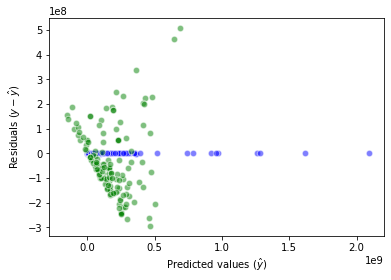

In [23]:
%matplotlib inline

# 1 - 
from sklearn.metrics import mean_squared_error
import math
se = math.sqrt(mean_squared_error(y_train, gs_svr.predict(X_train)))
print('Standard error:', se)
print('\nPredictions should be within {:.1f}M dollars at 95% confidence according to training data.'.format(2*se/1e6))
se_test = math.sqrt(mean_squared_error(y_test, gs_svr.predict(X_test)))
print('Predictions should be within {:.1f}M dollars at 95% confidence according to test data.'.format(2*se_test/1e6))

# 2a - Training residuals are nearly zero for most movies with a few exceptions.
#     This may indicate overfitting. The residual plot for test data is OK.
import matplotlib.pyplot as plt
print('\nResidual plot for training data (blue) and test data (green) below')
_ = plt.scatter(gs_svr.predict(X_train), y_train-gs_svr.predict(X_train), c='blue', s=40, alpha=0.5, edgecolor='white')
_ = plt.scatter(gs_svr.predict(X_test), y_test-gs_svr.predict(X_test), c='green', s=40, alpha=0.5, edgecolor='white')
_ = plt.plot([-10,50], [0,0], c='black')
_ = plt.ylabel('Residuals ($y - \hat{y}$)')
_ = plt.xlabel('Predicted values ($\hat{y}$)')

# 2 - More data!!!
#     It would be better to have another chunk of data, e.g., from 2012.
#     Then we could train on 2012 and tune our parameters on 2013.
#     2014 could then serve as a final held-out test set to evaluate generalisation.
#     It may be better to predict return / budget instead of the raw return value.
#     We should also compare to a baseline model, e.g., using budget to predict gross return.
#     Wikipedia is a bad source of descriptions for our scenario, since it is constantly
#     edited and so we have data leakage. We could use the version of the Wikipedia
#     abstract from when the movie was released.
#     Printing the highest-weighted features highlights issues of data leakage..
steps = dict(gs_svr.best_estimator_.steps) # access pipeline components directly
vect = steps['vect'] # vectorizer component
clf = steps['clf'] # classifier component
feature_weights = clf.coef_
feature_names = vect.get_feature_names()
print('\nTop 20 features:')
sorted(zip(feature_weights, feature_names), reverse=True)[:20] # print top 20 features

# 3 - No way would I deploy. The data leakage here means we can't trust this experiment setup.

# 4 - We could try the ratio of gross to budget, then multiply a prediction by
#     budget to get predicted gross.

# 5 - Reviews, e.g., from Metacritic or Rotten Tomatoes.
#     http://www.metacritic.com/feature/film-quality-vs-box-office-grosses
#     Here it would be good to compare to a baseline that predicts gross based on star ratings.